In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import SpectralClustering
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.decomposition import PCA
from sklearn import metrics

%matplotlib inline

In [2]:
boston = pd.read_csv('results.csv')
boston_cl = boston.drop(['name', 'gender', 'bib', 'ctz', 'genderdiv', 'division',
                     'country', 'city', 'state'], axis=1)
boston_cl = boston_cl.dropna()
boston_cl = boston_cl[boston_cl['10k'] != '-']
boston_cl = boston_cl[boston_cl['25k'] != '-']
boston_cl = boston_cl[boston_cl['35k'] != '-']
boston_cl = boston_cl[boston_cl['30k'] != '-']
boston_cl = boston_cl[boston_cl['5k'] != '-']
boston_cl = boston_cl[boston_cl['20k'] != '-']
boston_cl = boston_cl[boston_cl['40k'] != '-']
boston_cl = boston_cl[boston_cl['half'] != '-']

In [3]:
boston_cl['10k'] = boston_cl['10k'].astype('float64')
boston_cl['25k'] = boston_cl['25k'].astype('float64')
boston_cl['35k'] = boston_cl['30k'].astype('float64')
boston_cl['30k'] = boston_cl['30k'].astype('float64')
boston_cl['5k'] = boston_cl['30k'].astype('float64')
boston_cl['20k'] = boston_cl['30k'].astype('float64')
boston_cl['40k'] = boston_cl['30k'].astype('float64')
boston_cl['half'] = boston_cl['half'].astype('float64')
boston_cl['pace'] = boston_cl['pace'].astype('float64')
boston_cl['official'] = boston_cl['official'].astype('float64')
boston_cl['overall'] = boston_cl['overall'].astype('float64')

In [4]:
scaler = StandardScaler()
scaler.fit(boston_cl)
boston_n = pd.DataFrame(scaler.transform(boston_cl), columns=boston_cl.columns, index=boston_cl.index)

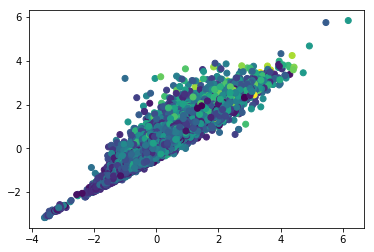

In [5]:
plt.scatter(boston_n['half'], boston_n['official'], c=boston_n['age']);

In [6]:
boston_c = boston_n[['official', 'pace', 'age', 'half', '5k', '30k']]

In [7]:
pca = PCA(n_components=2)
pca.fit(boston_c);

In [8]:
pca_df = pd.DataFrame(pca.transform(boston_c), index=boston_c.index, dtype=np.float64)

In [9]:
verbose = False
n_clusters = [2, 3, 4, 5, 6, 7, 8]
samples = 50
c1_deviation = []
c2_deviation = []
for n_c in n_clusters:
    if verbose:
        print("Clusters: ", n_c)
    scores = []
    means = []
    medians = []
    stds = []
    for sample in range(samples):
        pca_df_samp = pca_df.sample(frac=0.25)
        kmeans = KMeans(n_clusters=n_c, random_state=42).fit(pca_df_samp)
        y_pred = kmeans.predict(pca_df_samp)
        scores.append(metrics.calinski_harabaz_score(pca_df_samp, kmeans.labels_))
        means.append((pca_df_samp[0].mean(), pca_df_samp[1].mean()))
        medians.append((pca_df_samp[0].median(), pca_df_samp[1].median()))
        stds.append((pca_df_samp[0].std(), pca_df_samp[1].std()))
    if verbose:
        print("Score: ", np.mean(scores))
    means, stds, medians = np.array(means), np.array(stds), np.array(medians)
    if verbose:
        print()
        print("Cross Sample Comparisons")
        print("------------------------")
        print("First Component")
        print("Means Deviation:   ", means[:, 0].std())
        print("Medians Deviation: ", medians[:, 0].std())
        print("Stds Deviation:    ", stds[:, 0].std())
    c1_deviation.append((means[:, 0].std(), medians[:, 0].std(),
                            stds[:, 0].std()))
    if verbose:
        print("Second Component")
        print("Means Deviation:   ", means[:, 1].std())
        print("Medians Deviation: ", medians[:, 1].std())
        print("Stds Deviation:    ", stds[:, 1].std())  
    c2_deviation.append((means[:, 1].std(), medians[:, 1].std(),
                        stds[:, 1].std()))
    if verbose:
        print()

c1_deviation = np.array(c1_deviation)
c2_deviation = np.array(c2_deviation)

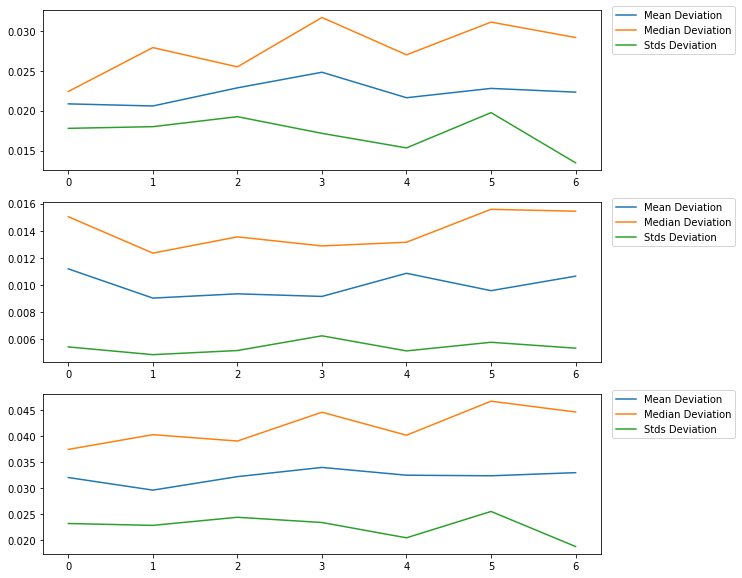

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(10,10))
plt.subplot(311)
plt.plot(c1_deviation[:, 0], label="Mean Deviation")
plt.plot(c1_deviation[:, 1], label="Median Deviation")
plt.plot(c1_deviation[:, 2], label="Stds Deviation")
plt.legend(loc='upper right', bbox_to_anchor=(1.25,1.055))
plt.subplot(312)
plt.plot(c2_deviation[:, 0], label="Mean Deviation")
plt.plot(c2_deviation[:, 1], label="Median Deviation")
plt.plot(c2_deviation[:, 2], label="Stds Deviation")
plt.legend(loc='upper right', bbox_to_anchor=(1.25,1.055))
plt.subplot(313)
plt.plot((c1_deviation+c2_deviation)[:, 0], label="Mean Deviation")
plt.plot((c1_deviation+c2_deviation)[:, 1], label="Median Deviation")
plt.plot((c1_deviation+c2_deviation)[:, 2], label="Stds Deviation")
plt.legend(loc='upper right', bbox_to_anchor=(1.25,1.055));

In [11]:
def eval_cluster_model(model, samples=5):
    c1_deviation = []
    c2_deviation = []
    scores = []
    means = []
    medians = []
    stds = []
    for sample in range(samples):
        pca_df_samp = pca_df.sample(frac=0.25)
        model.fit(pca_df_samp)
        scores.append(metrics.calinski_harabaz_score(pca_df_samp, model.labels_))
        means.append((pca_df_samp[0].mean(), pca_df_samp[1].mean()))
        medians.append((pca_df_samp[0].median(), pca_df_samp[1].median()))
        stds.append((pca_df_samp[0].std(), pca_df_samp[1].std()))
    print("Score: ", np.mean(scores))
    means, stds, medians = np.array(means), np.array(stds), np.array(medians)
    print()
    print("Cross Sample Comparisons")
    print("------------------------")
    print("First Component")
    print("Means Deviation:   ", means[:, 0].std())
    print("Medians Deviation: ", medians[:, 0].std())
    print("Stds Deviation:    ", stds[:, 0].std())
    c1_deviation.append((means[:, 0].std(), medians[:, 0].std(),
                            stds[:, 0].std()))
    print("Second Component")
    print("Means Deviation:   ", means[:, 1].std())
    print("Medians Deviation: ", medians[:, 1].std())
    print("Stds Deviation:    ", stds[:, 1].std())  
    c2_deviation.append((means[:, 1].std(), medians[:, 1].std(),
                        stds[:, 1].std()))
    print()

    c1_deviation = np.array(c1_deviation)
    c2_deviation = np.array(c2_deviation)
    
    return c1_deviation, c2_deviation, model

In [12]:
bandwidth = estimate_bandwidth(pca_df, quantile=0.1, n_samples=500)
print(bandwidth)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
eval_cluster_model(ms, samples=20)

1.12077122112
Score:  1059.9429513

Cross Sample Comparisons
------------------------
First Component
Means Deviation:    0.0191792325497
Medians Deviation:  0.0280276861695
Stds Deviation:     0.0151484422978
Second Component
Means Deviation:    0.00959871533717
Medians Deviation:  0.014234047673
Stds Deviation:     0.00683036701018



(array([[ 0.01917923,  0.02802769,  0.01514844]]),
 array([[ 0.00959872,  0.01423405,  0.00683037]]),
 MeanShift(bandwidth=1.1207712211207568, bin_seeding=True, cluster_all=True,
      min_bin_freq=1, n_jobs=1, seeds=None))

In [13]:
kmeans = KMeans(n_clusters=6, random_state=42).fit(pca_df)

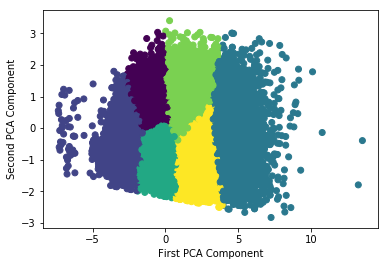

In [14]:
y_pred = kmeans.predict(pca_df)
plt.scatter(pca_df[0], pca_df[1], c=y_pred);
plt.xlabel("First PCA Component")
plt.ylabel("Second PCA Component");

In [15]:
boston_an = boston.loc[boston_cl.index, :].copy()

In [16]:
boston_an['cluster'] = y_pred

# Cluster Exploration

We now explore our clusters along a few parameters, focusing on the differences in the pace between genders. First, we look at the mean pace in each cluster. As this was a factor in choosing our clusters, we expect to see reliable differences between the clusters. 

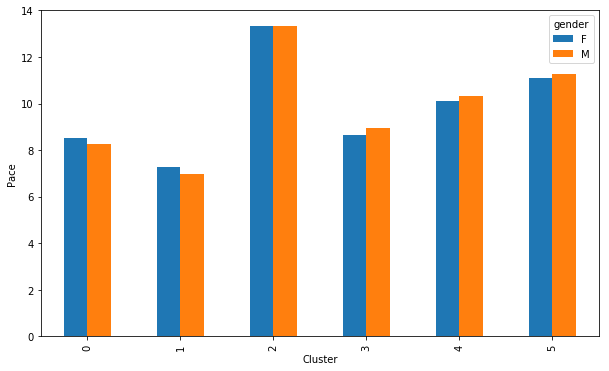

In [17]:
boston_an.groupby(['cluster', 'gender'])['pace'].mean().unstack('gender').plot.bar(figsize=(10,6));
plt.xlabel("Cluster")
plt.ylabel("Pace");

As expected there are regular differences in pace between the clusters. Also note that there isn't any significant difference between the pace of the grouped genders in each cluster. 

We now seek to understand whether some of the difference between pace in each cluster can be explained by other parameters before we consider the proportion of genders in each cluster. First, we're going to ensure that there's not significant differences in age that may be affecting the pace other than gender.

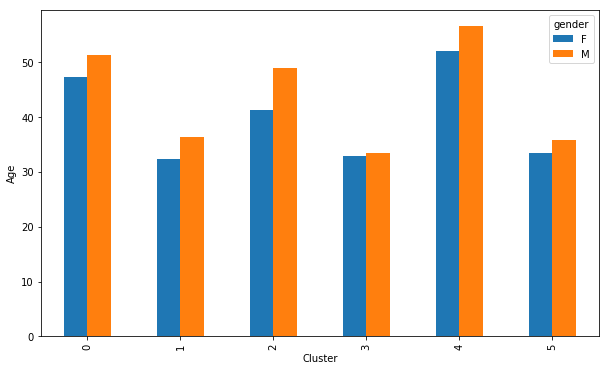

In [18]:
boston_an.groupby(['cluster', 'gender'])['age'].mean().unstack('gender').plot.bar(figsize=(10,6));
plt.xlabel("Cluster")
plt.ylabel("Age");

There is a larger difference in the age composition of male vs female in each gender than we saw with pace, but the clusters are mostly consistent in age, and we also see that the age of the female proportion of each cluster is generally lower. Thus, we would expect that this would decrease the pace of the male group.

Finally, we look at the actual proportion of males and females in each cluster.

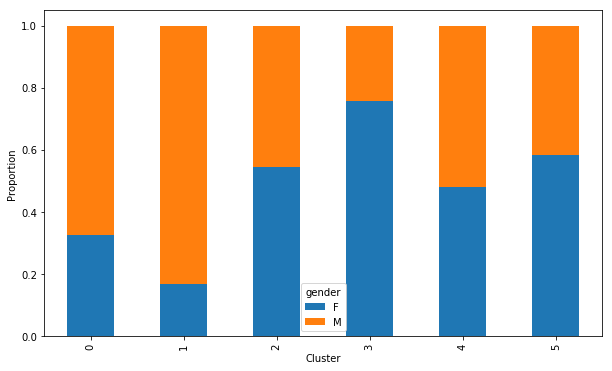

In [19]:
(boston_an.groupby(['cluster'])['gender'].value_counts()/boston_an.groupby(['cluster']).size()) \
        .unstack('gender').plot.bar(stacked=True, figsize=(10,6))
plt.xlabel("Cluster")
plt.ylabel("Proportion");

And we notice that clusters 0 and 1, have significantly larger percentages of males, while cluster 3 has a larger percentage of females, with 2, 4, and 5 being about evenly distributed. We compare this again with the pace of each cluster.

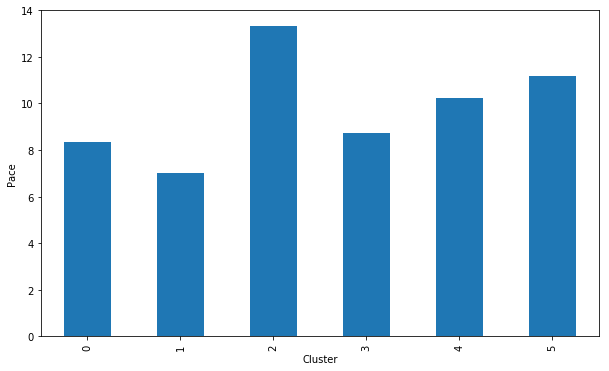

In [20]:
boston_an.groupby(['cluster'])['pace'].mean().plot.bar(figsize=(10,6));
plt.xlabel("Cluster")
plt.ylabel("Pace");

Thus, we note that cluster 1, which has the fastest pace, is composed mostly of males which suggests that males tend to perform better in the Boston Marathon or that it draws more top tier male athletes than female. However, we also note that cluster 0, is predomantly male and has a comparable pace to cluster 3 which is composed mainly of females. This suggests a mid-range group of marathon enthusiasts who all perform roughly equally regardless of gender. Though we note that cluster 0 is older than cluster 3. 

# Appendix: Cluster Plots

Clusters:  2
Score:  9978.18698695

Cross Sample Comparisons
------------------------
First Component
Means Deviation:    0.0109956969526
Medians Deviation:  0.0248368639426
Stds Deviation:     0.0143308040914
Second Component
Means Deviation:    0.00102723624096
Medians Deviation:  0.00427343335167
Stds Deviation:     0.00429392798547

Clusters:  3
Score:  9249.50107295

Cross Sample Comparisons
------------------------
First Component
Means Deviation:    0.00525554045804
Medians Deviation:  0.0060035322017
Stds Deviation:     0.0134050815988
Second Component
Means Deviation:    0.00843157934986
Medians Deviation:  0.00880859544019
Stds Deviation:     0.0060473779084

Clusters:  4
Score:  8323.20896747

Cross Sample Comparisons
------------------------
First Component
Means Deviation:    0.0236036306948
Medians Deviation:  0.021168165383
Stds Deviation:     0.010873366916
Second Component
Means Deviation:    0.00589193251299
Medians Deviation:  0.00787952959726
Stds Deviation:     0.0

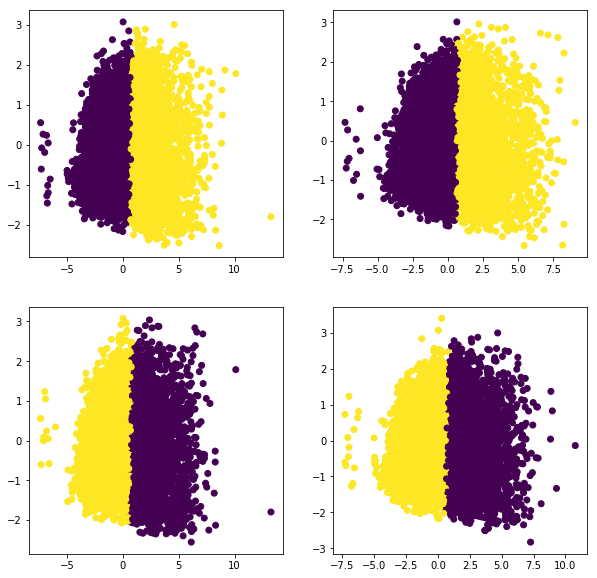

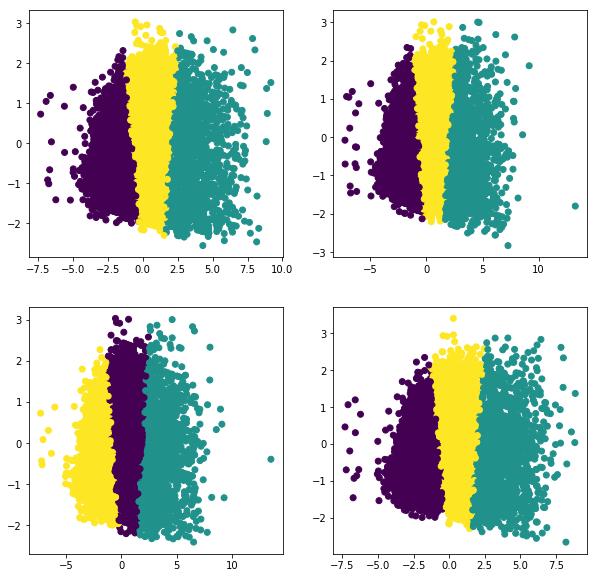

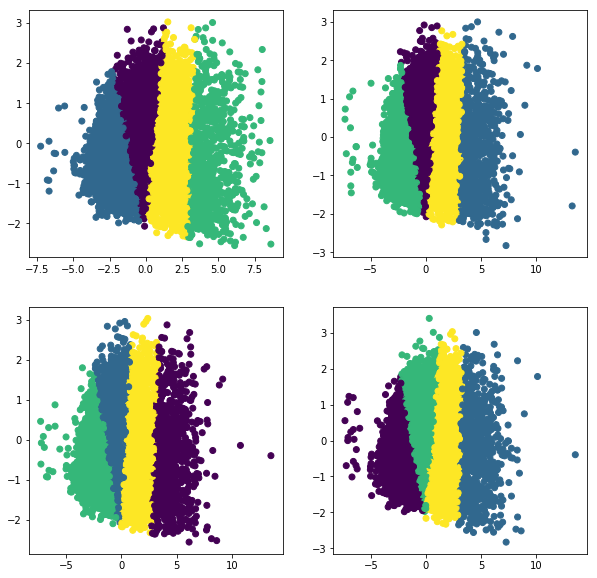

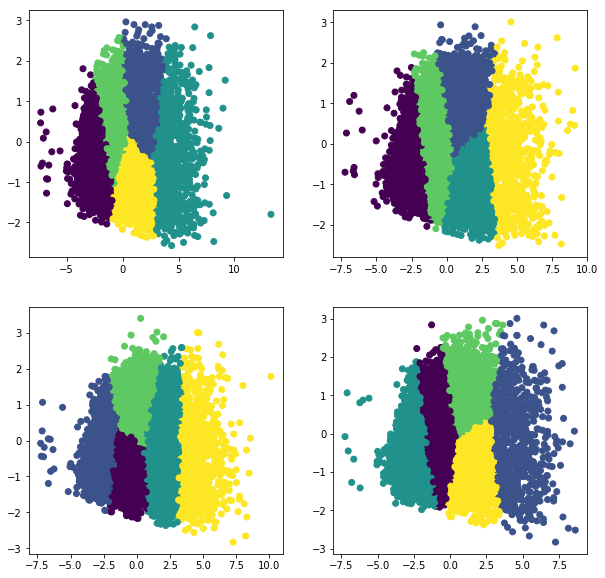

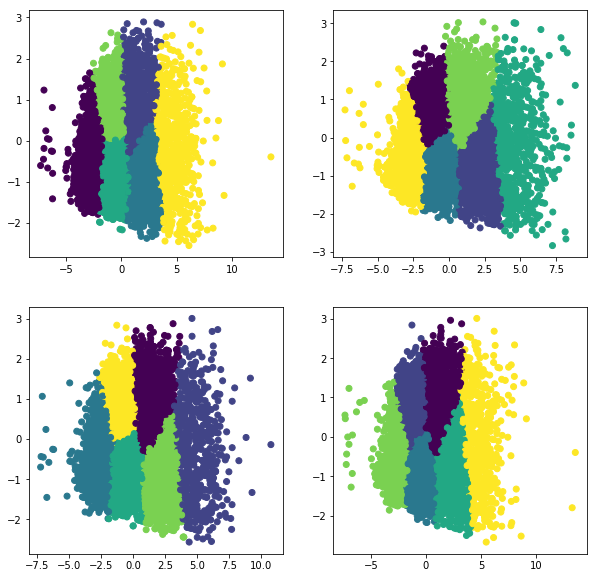

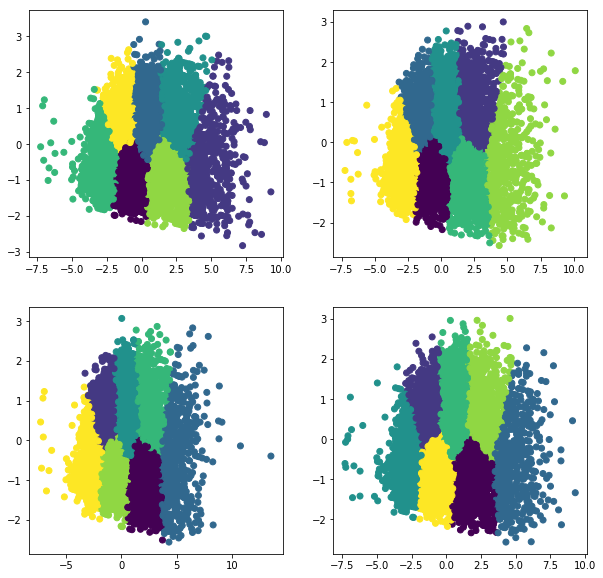

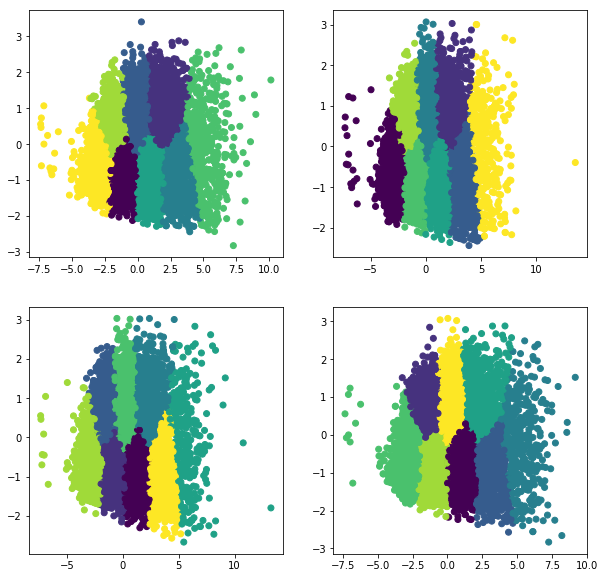

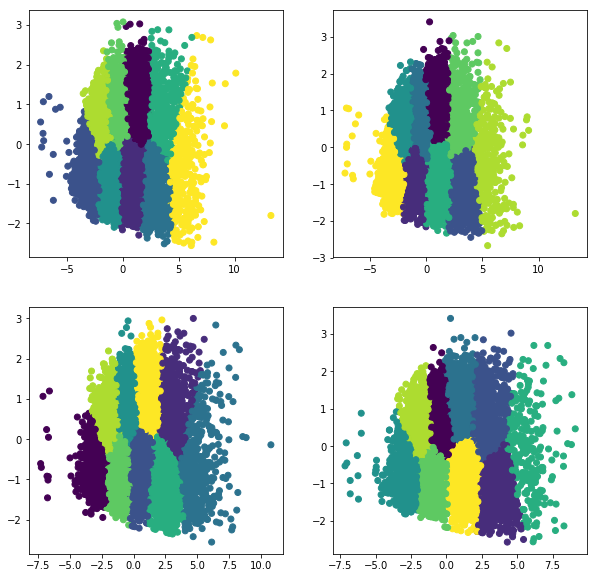

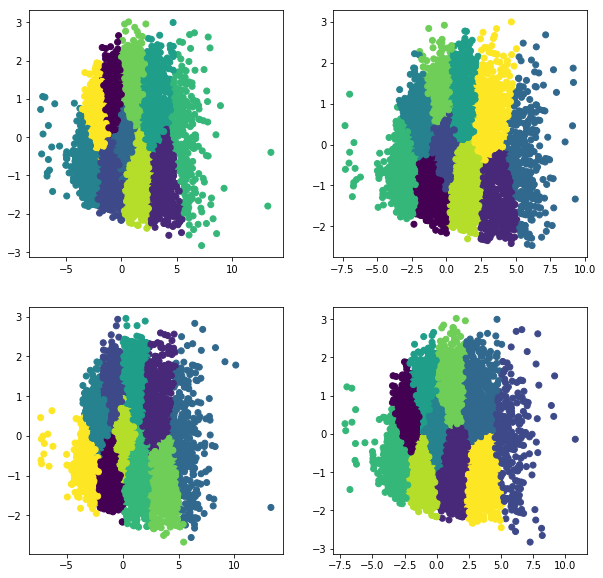

In [21]:
n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]
samples = 4
for n_c in n_clusters:
    print("Clusters: ", n_c)
    plt.figure(figsize=(10,10))
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))
    axs = [ax1, ax2, ax3, ax4]
    scores = []
    means = []
    medians = []
    stds = []
    for ax in axs:
        pca_df_samp = pca_df.sample(frac=0.25)
        kmeans = KMeans(n_clusters=n_c, random_state=42).fit(pca_df_samp)
        y_pred = kmeans.predict(pca_df_samp)
        ax.scatter(pca_df_samp[0], pca_df_samp[1], c=y_pred)
        scores.append(metrics.calinski_harabaz_score(pca_df_samp, kmeans.labels_))
        means.append((pca_df_samp[0].mean(), pca_df_samp[1].mean()))
        medians.append((pca_df_samp[0].median(), pca_df_samp[1].median()))
        stds.append((pca_df_samp[0].std(), pca_df_samp[1].std()))
    print("Score: ", np.mean(scores))
    means, stds, medians = np.array(means), np.array(stds), np.array(medians)
    print()
    print("Cross Sample Comparisons")
    print("------------------------")
    print("First Component")
    print("Means Deviation:   ", means[:, 0].std())
    print("Medians Deviation: ", medians[:, 0].std())
    print("Stds Deviation:    ", stds[:, 0].std())
    print("Second Component")
    print("Means Deviation:   ", means[:, 1].std())
    print("Medians Deviation: ", medians[:, 1].std())
    print("Stds Deviation:    ", stds[:, 1].std())    
    print()

# Appendix: Other Plots and Exploration

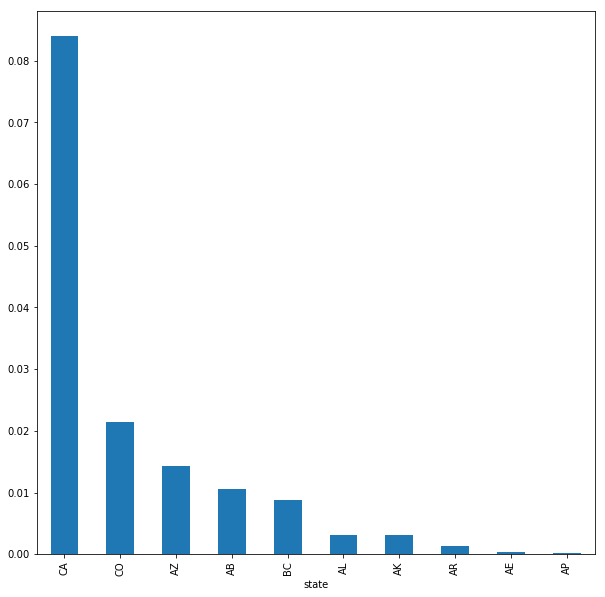

In [22]:
plt.figure(figsize=(10,10))
(boston_an.groupby(['cluster', 'state']).size()/boston_an.groupby(['cluster']).size())[0][:10] \
        .sort_values(ascending=False).plot.bar()

In [23]:
# https://stackoverflow.com/questions/23377108/pandas-percentage-of-total-with-groupby
boston_an.groupby(['cluster', 'state']).size()

cluster  state
0        AB        80
         AE         3
         AK        23
         AL        24
         AP         1
         AR        10
         AZ       108
         BC        66
         CA       635
         CO       162
         CT       159
         DC        26
         DE        18
         FL       215
         GA       130
         HI        19
         IA        48
         ID        42
         IL       245
         IN        96
         KS        44
         KY        35
         LA        12
         MA       550
         MB        13
         MD       160
         ME        86
         MI       205
         MN       154
         MO        69
                 ... 
5        MO        13
         MS         4
         NB         1
         NC        46
         NE         5
         NH        88
         NJ        32
         NL         1
         NM         2
         NS         3
         NV         3
         NY       119
         OH        31
         OK      